# Exploring Positional Encoding Effects in Transformer Classifiers

This notebook investigates how different positional encoding strategies affect transformer representations for the 4t vs background classification task.

## Overview

We'll analyze four trained models with different positional encodings:
1. **None** - No positional information (permutation invariant)
2. **Sinusoidal** - Fixed sin/cos patterns from "Attention is All You Need"
3. **Learned** - Trainable positional embeddings
4. **Rotary (RoPE)** - Rotary position embeddings applied in attention

## Key Questions
- How do positional encodings look in model dimensions?
- How do they affect representations layer-by-layer through the transformer?
- Why does positional encoding improve performance?
- What's the difference between sinusoidal, learned, and rotary approaches?

In [1]:
# Imports
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf

# Add project root to path
project_root = Path(r"C:\Users\niels\Projects\Thesis-Code\Code\Niels_repo")
sys.path.insert(0, str(project_root / "src"))  # noqa: E402

from thesis_ml.data.h5_loader import make_classification_dataloaders  # noqa: E402

# Plotting setup
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
%matplotlib inline

print("✓ Imports successful")

✓ Imports successful


## 1. Load All Four Models

Load the trained models with different positional encodings from the experiment directory.

In [2]:
# Define paths
models_root = Path(r"C:\Users\niels\Projects\Thesis-Code\Saved models\20251127-162910_4t_vs_background_postional")
data_path = Path(r"C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5")

# Load all four models
models_info = {}
run_ids = [
    "run_20251127-162910_4t_vs_background_positional_job0",
    "run_20251127-162910_4t_vs_background_positional_job1",
    "run_20251127-162910_4t_vs_background_positional_job2",
    "run_20251127-162910_4t_vs_background_positional_job3",
]

# Import additional tools for manual loading
from thesis_ml.architectures.transformer_classifier.base import build_from_config as build_classifier  # noqa: E402
from thesis_ml.training_loops.transformer_classifier import _gather_meta  # noqa: E402

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading models...")
for run_id in run_ids:
    try:
        # Direct path construction
        run_dir = models_root / run_id
        cfg_path = run_dir / ".hydra" / "config.yaml"
        
        if not cfg_path.exists():
            print(f"✗ Config not found: {cfg_path}")
            continue
        
        # Load config
        cfg = OmegaConf.load(str(cfg_path))
        
        # Override data path
        cfg.data.path = str(data_path)
        
        # Populate meta if missing
        if not hasattr(cfg, "meta") or cfg.meta is None:
            train_dl_temp, val_dl_temp, test_dl_temp, meta = make_classification_dataloaders(cfg)
            _gather_meta(cfg, meta)
        
        # Build model
        model = build_classifier(cfg, cfg.meta).to(device)
        
        # Load weights
        best_val_path = run_dir / "best_val.pt"
        model_pt_path = run_dir / "model.pt"
        
        if best_val_path.exists():
            weights_path = best_val_path
        elif model_pt_path.exists():
            weights_path = model_pt_path
        else:
            print(f"✗ No weights found in {run_dir}")
            continue
        
        checkpoint = torch.load(str(weights_path), map_location=device, weights_only=False)
        state_dict = checkpoint["model_state_dict"] if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint else checkpoint

        # Quick compatibility hack for older learned-PE checkpoints trained
        # before CLS tokens were prepended to the sequence:
        #   - Old checkpoints store pos_enc.pe with shape [18, D]
        #   - New models expect [19, D] because CLS is added.
        # Here we drop the old pos_enc.pe so the new parameter is used.
        pos_enc_type = cfg.classifier.model.get("positional", "unknown")
        pooling_type = cfg.classifier.model.get("pooling", "cls")
        if pos_enc_type == "learned" and pooling_type == "cls":
            state_dict = {k: v for k, v in state_dict.items() if not k.startswith("pos_enc.pe")}
            model.load_state_dict(state_dict, strict=False)
        else:
            model.load_state_dict(state_dict)

        model.eval()

        models_info[pos_enc_type] = {
            "run_id": run_id,
            "cfg": cfg,
            "model": model,
            "device": device,
        }
        
        print(f"✓ Loaded {run_id}")
        print(f"  Positional encoding: {pos_enc_type}")
        print(f"  Model dim: {cfg.classifier.model.dim}")
        print(f"  Layers: {cfg.classifier.model.depth}")
        print(f"  Heads: {cfg.classifier.model.heads}")
        print()
        
    except Exception as e:
        print(f"✗ Failed to load {run_id}: {e}")
        import traceback
        traceback.print_exc()
        print()

print(f"\nSuccessfully loaded {len(models_info)} models:")
print(f"Positional encoding types: {list(models_info.keys())}")

Loading models...
✓ Loaded run_20251127-162910_4t_vs_background_positional_job0
  Positional encoding: none
  Model dim: 256
  Layers: 6
  Heads: 8

✓ Loaded run_20251127-162910_4t_vs_background_positional_job1
  Positional encoding: sinusoidal
  Model dim: 256
  Layers: 6
  Heads: 8

✓ Loaded run_20251127-162910_4t_vs_background_positional_job2
  Positional encoding: learned
  Model dim: 256
  Layers: 6
  Heads: 8

✓ Loaded run_20251127-162910_4t_vs_background_positional_job3
  Positional encoding: rotary
  Model dim: 256
  Layers: 6
  Heads: 8


Successfully loaded 4 models:
Positional encoding types: ['none', 'sinusoidal', 'learned', 'rotary']


In [3]:
# Load dataset (use config from first model)
sample_cfg = next(iter(models_info.values()))["cfg"]

# Override data path to use our specified location
sample_cfg.data.path = str(data_path)

print("Loading dataset...")
train_dl, val_dl, test_dl, meta = make_classification_dataloaders(sample_cfg)

print("✓ Dataset loaded")
print(f"  Path: {data_path}")
print(f"  n_tokens: {meta['n_tokens']}")
print(f"  n_classes: {meta['n_classes']}")
print(f"  has_globals: {meta['has_globals']}")
print(f"  Train batches: {len(train_dl)}")
print(f"  Val batches: {len(val_dl)}")
print(f"  Test batches: {len(test_dl)}")

Loading dataset...
✓ Dataset loaded
  Path: C:\Users\niels\Projects\Thesis-Code\Data\4tops_splitted.h5
  n_tokens: 18
  n_classes: 2
  has_globals: True
  Train batches: 3776
  Val batches: 472
  Test batches: 472


## 2. Visualize Raw Positional Encoding Patterns

Extract and visualize the positional encoding matrices before they're added to embeddings.

**Note:** Rotary encoding doesn't have an additive positional encoding matrix - it applies rotations inside the attention mechanism.

In [4]:
# Extract positional encoding matrices
pe_matrices = {}

for pe_type, info in models_info.items():
    model = info["model"]
    
    if pe_type == "none":
        # No positional encoding
        pe_matrices[pe_type] = None
        print(f"{pe_type}: No positional encoding (identity)")
        
    elif pe_type == "rotary":
        # Rotary is applied in attention, not additive
        # Extract the cached sin/cos patterns after they're computed
        rotary_emb = model.encoder.rotary_emb
        if rotary_emb is not None:
            print(f"{pe_type}: Applied in attention mechanism (not additive)")
            print(f"  head_dim: {rotary_emb.head_dim}")
            print(f"  base: {rotary_emb.base}")
            # We'll visualize this differently later
            pe_matrices[pe_type] = None
        else:
            print(f"{pe_type}: No rotary embedding found")
            pe_matrices[pe_type] = None
            
    else:
        # Sinusoidal or Learned
        pos_enc = model.pos_enc
        if pos_enc is not None and hasattr(pos_enc, 'pe'):
            pe_matrix = pos_enc.pe.detach().cpu().numpy()
            pe_matrices[pe_type] = pe_matrix
            print(f"{pe_type}: Shape {pe_matrix.shape} (tokens × model_dim)")
        else:
            pe_matrices[pe_type] = None
            print(f"{pe_type}: No positional encoding matrix found")

print("\n✓ Extracted positional encoding patterns")

none: No positional encoding (identity)
sinusoidal: Shape (19, 256) (tokens × model_dim)
learned: Shape (19, 256) (tokens × model_dim)
rotary: Applied in attention mechanism (not additive)
  head_dim: 32
  base: 10000.0

✓ Extracted positional encoding patterns


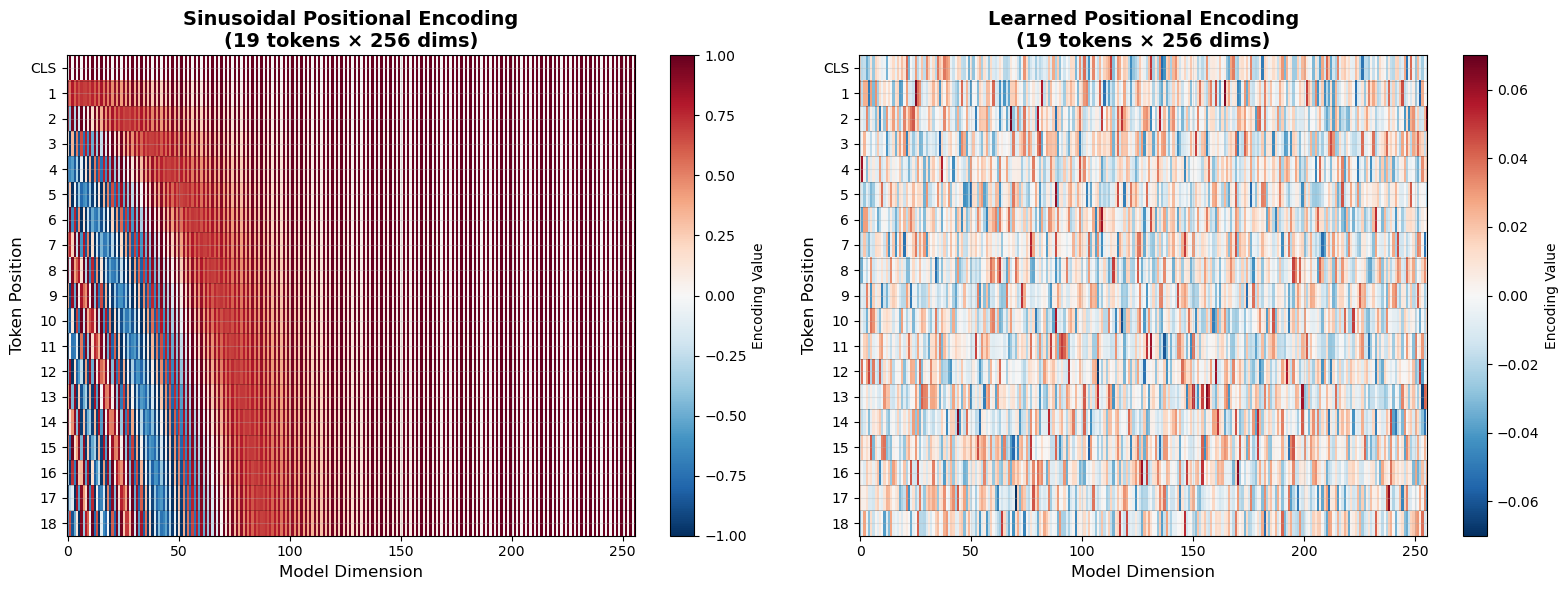

Heatmap shows how each position is encoded across all model dimensions


In [5]:
# Visualize positional encoding matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_types = ['sinusoidal', 'learned']
for idx, pe_type in enumerate(plot_types):
    ax = axes[idx]
    
    if pe_type in pe_matrices and pe_matrices[pe_type] is not None:
        pe_matrix = pe_matrices[pe_type]
        num_tokens = pe_matrix.shape[0]

        # Plot heatmap (no interpolation so each token is a flat band)
        im = ax.imshow(
            pe_matrix,
            aspect='auto',
            cmap='RdBu_r',
            vmin=-np.abs(pe_matrix).max(),
            vmax=np.abs(pe_matrix).max(),
            interpolation='nearest',
        )
        ax.set_xlabel('Model Dimension', fontsize=12)
        ax.set_ylabel('Token Position', fontsize=12)
        ax.set_title(
            f'{pe_type.capitalize()} Positional Encoding\n({num_tokens} tokens × {pe_matrix.shape[1]} dims)',
            fontsize=14,
            fontweight='bold',
        )

        # Show one tick per token (CLS + 18 physics tokens = 19 positions)
        y_ticks = np.arange(num_tokens)
        y_labels = ['CLS'] + [str(i) for i in range(1, num_tokens)] if num_tokens > 0 else []
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)

        # Draw horizontal grid lines between tokens
        for y in np.arange(num_tokens + 1) - 0.5:
            ax.axhline(y, color='k', linewidth=0.5, alpha=0.3)

        plt.colorbar(im, ax=ax, label='Encoding Value')
    else:
        ax.text(0.5, 0.5, f'{pe_type.capitalize()}\nNot available', 
                ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

print("Heatmap shows how each position is encoded across all model dimensions")

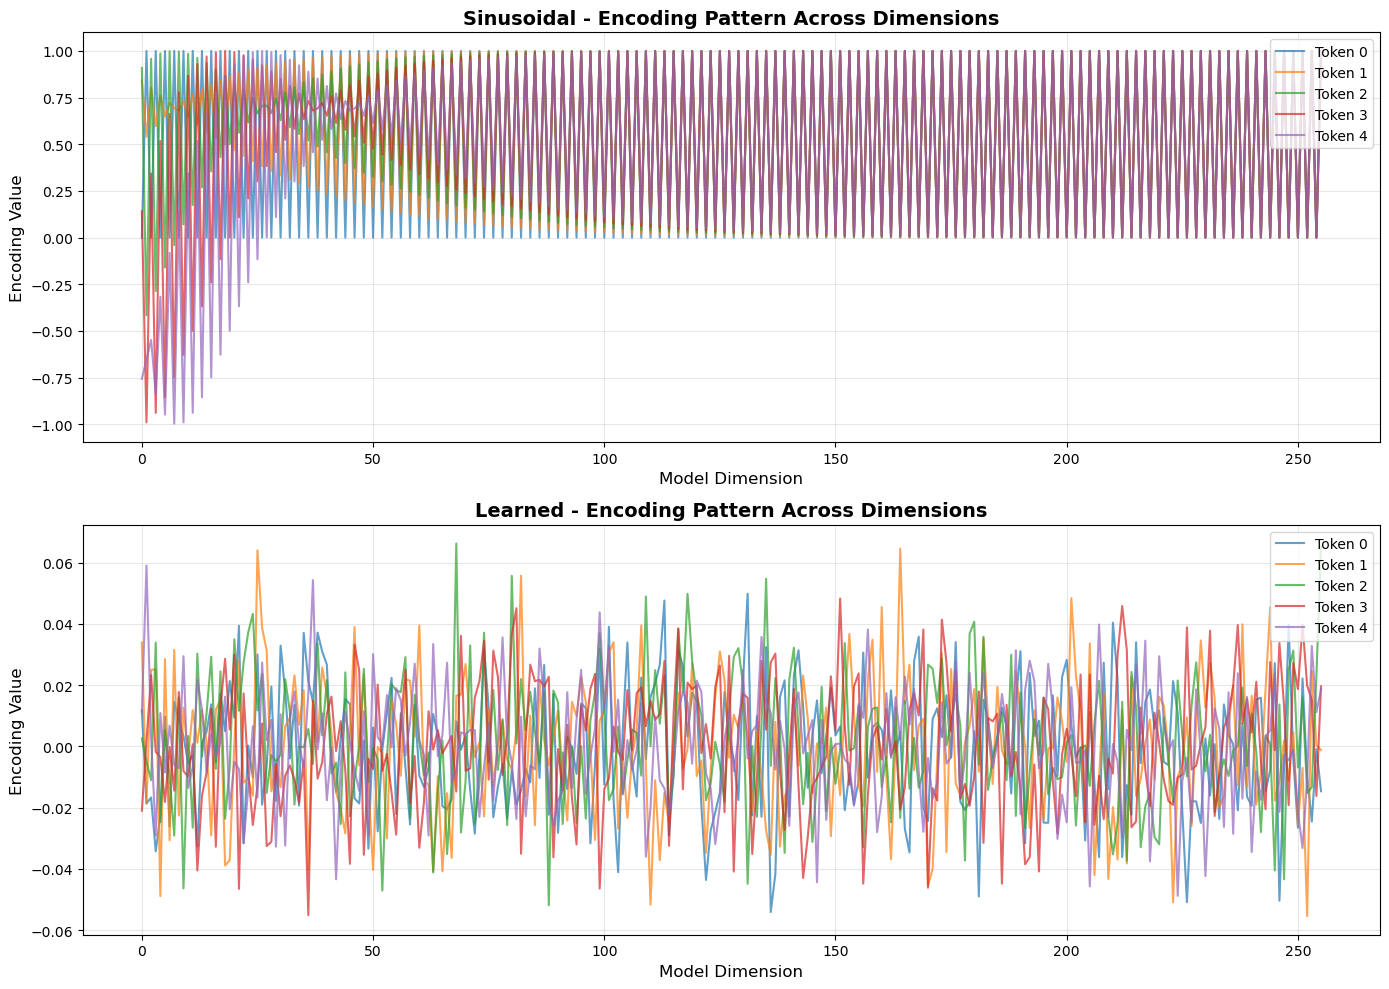


Observations:
- Sinusoidal: Smooth wave patterns with different frequencies per dimension
- Learned: Random-initialized patterns that were optimized during training


In [6]:
# Visualize per-token patterns: show how each token's encoding varies across dimensions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

plot_types = ['sinusoidal', 'learned']
for idx, pe_type in enumerate(plot_types):
    ax = axes[idx]
    
    if pe_type in pe_matrices and pe_matrices[pe_type] is not None:
        pe_matrix = pe_matrices[pe_type]
        
        # Plot first 5 tokens to show pattern
        tokens_to_plot = min(5, pe_matrix.shape[0])
        for token_idx in range(tokens_to_plot):
            ax.plot(pe_matrix[token_idx, :], label=f'Token {token_idx}', alpha=0.7)
        
        ax.set_xlabel('Model Dimension', fontsize=12)
        ax.set_ylabel('Encoding Value', fontsize=12)
        ax.set_title(f'{pe_type.capitalize()} - Encoding Pattern Across Dimensions', 
                     fontsize=14, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{pe_type.capitalize()}\nNot available', 
                ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Sinusoidal: Smooth wave patterns with different frequencies per dimension")
print("- Learned: Random-initialized patterns that were optimized during training")

Visualizing Rotary (RoPE) sin/cos patterns...


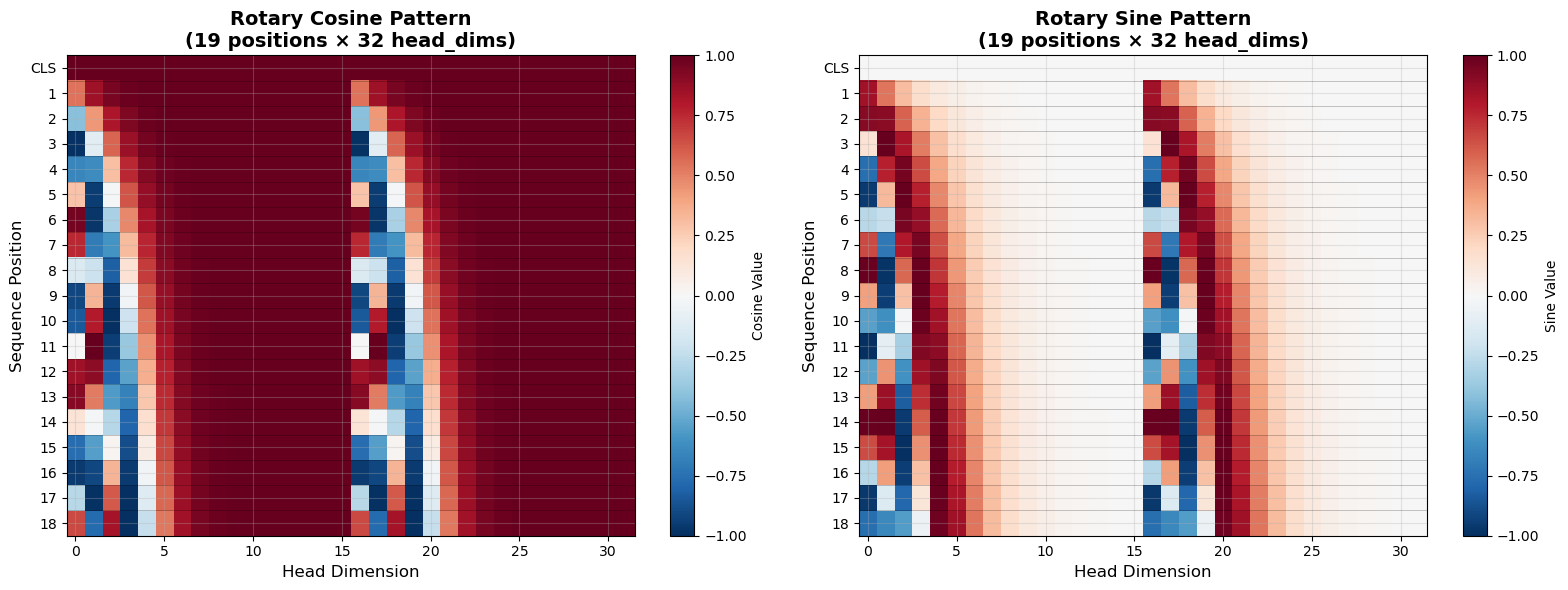

✓ Rotary patterns visualized
  These are applied to Q and K in attention, not added to embeddings


In [7]:
# For Rotary: visualize the sin/cos patterns
# Need to trigger a forward pass first to populate the cache

print("Visualizing Rotary (RoPE) sin/cos patterns...")
if 'rotary' in models_info:
    model = models_info['rotary']['model']
    rotary_emb = model.encoder.rotary_emb
    
    if rotary_emb is not None:
        # Get a sample batch to trigger forward pass
        sample_batch = next(iter(val_dl))
        device = models_info['rotary']['device']
        
        with torch.no_grad():
            # Forward pass to populate rotary cache
            if len(sample_batch) == 4:  # (tokens_cont, tokens_id, labels, mask)
                tokens_cont, tokens_id, labels, mask = sample_batch
                tokens_cont = tokens_cont.to(device)
                tokens_id = tokens_id.to(device)
                mask = mask.to(device)
                _ = model(tokens_cont, tokens_id, mask=mask)
            elif len(sample_batch) == 5:  # (tokens_cont, tokens_id, globals, mask, labels)
                tokens_cont, tokens_id, globals, mask, labels = sample_batch
                tokens_cont = tokens_cont.to(device)
                tokens_id = tokens_id.to(device)
                mask = mask.to(device)
                _ = model(tokens_cont, tokens_id, mask=mask)
            else:  # binned format
                tokens, labels, mask = sample_batch
                tokens = tokens.to(device)
                mask = mask.to(device)
                _ = model(tokens, mask=mask)
        
        # Extract cached sin/cos
        if hasattr(rotary_emb, '_cos_cached') and rotary_emb._cos_cached is not None:
            cos_cache = rotary_emb._cos_cached.squeeze().detach().cpu().numpy()  # [seq_len, head_dim]
            sin_cache = rotary_emb._sin_cached.squeeze().detach().cpu().numpy()
            
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            num_positions = cos_cache.shape[0]

            # Plot cos
            im0 = axes[0].imshow(
                cos_cache,
                aspect='auto',
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                interpolation='nearest',
            )
            axes[0].set_xlabel('Head Dimension', fontsize=12)
            axes[0].set_ylabel('Sequence Position', fontsize=12)
            axes[0].set_title(
                f'Rotary Cosine Pattern\n({num_positions} positions × {cos_cache.shape[1]} head_dims)',
                fontsize=14,
                fontweight='bold',
            )
            # Y-axis ticks and labels
            y_ticks = np.arange(num_positions)
            y_labels = ['CLS'] + [str(i) for i in range(1, num_positions)] if num_positions > 0 else []
            axes[0].set_yticks(y_ticks)
            axes[0].set_yticklabels(y_labels)
            # Horizontal lines between positions
            for y in np.arange(num_positions + 1) - 0.5:
                axes[0].axhline(y, color='k', linewidth=0.5, alpha=0.3)
            plt.colorbar(im0, ax=axes[0], label='Cosine Value')
            
            # Plot sin
            im1 = axes[1].imshow(
                sin_cache,
                aspect='auto',
                cmap='RdBu_r',
                vmin=-1,
                vmax=1,
                interpolation='nearest',
            )
            axes[1].set_xlabel('Head Dimension', fontsize=12)
            axes[1].set_ylabel('Sequence Position', fontsize=12)
            axes[1].set_title(
                f'Rotary Sine Pattern\n({num_positions} positions × {sin_cache.shape[1]} head_dims)',
                fontsize=14,
                fontweight='bold',
            )
            axes[1].set_yticks(y_ticks)
            axes[1].set_yticklabels(y_labels)
            for y in np.arange(num_positions + 1) - 0.5:
                axes[1].axhline(y, color='k', linewidth=0.5, alpha=0.3)
            plt.colorbar(im1, ax=axes[1], label='Sine Value')
            
            plt.tight_layout()
            plt.show()
            
            print("✓ Rotary patterns visualized")
            print("  These are applied to Q and K in attention, not added to embeddings")
        else:
            print("  No rotary cache populated (cache may not exist or forward pass didn't trigger it)")
else:
    print("  No rotary model loaded")

## RoPE visualization 

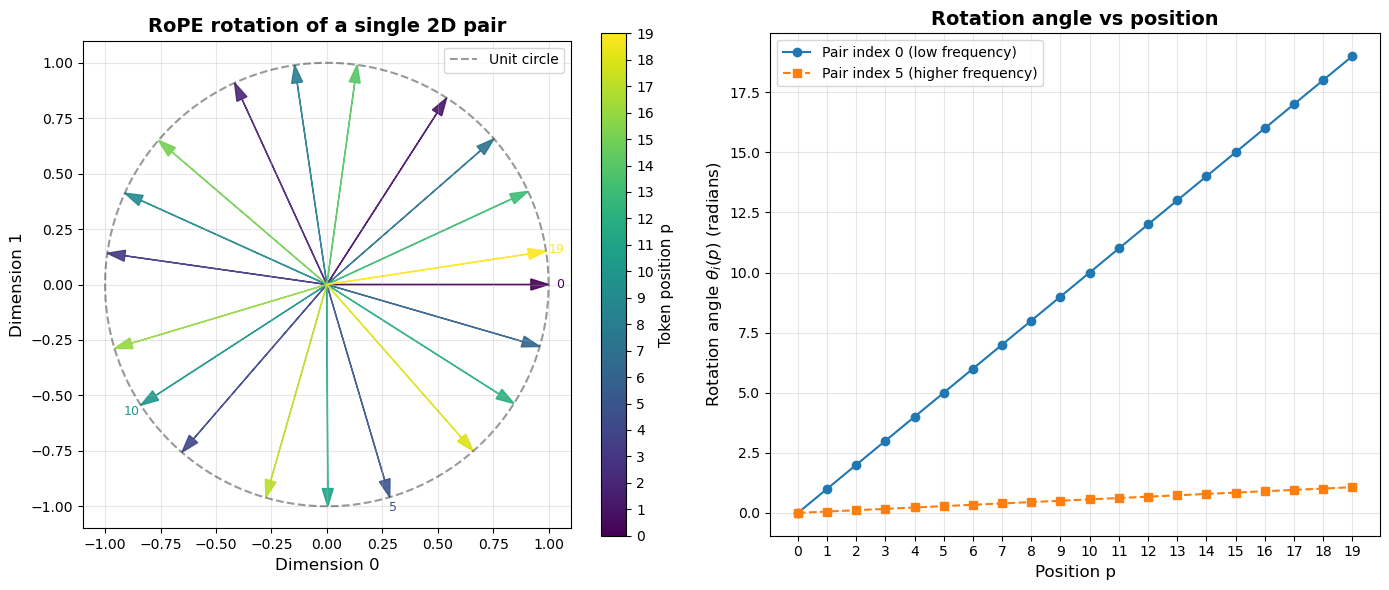

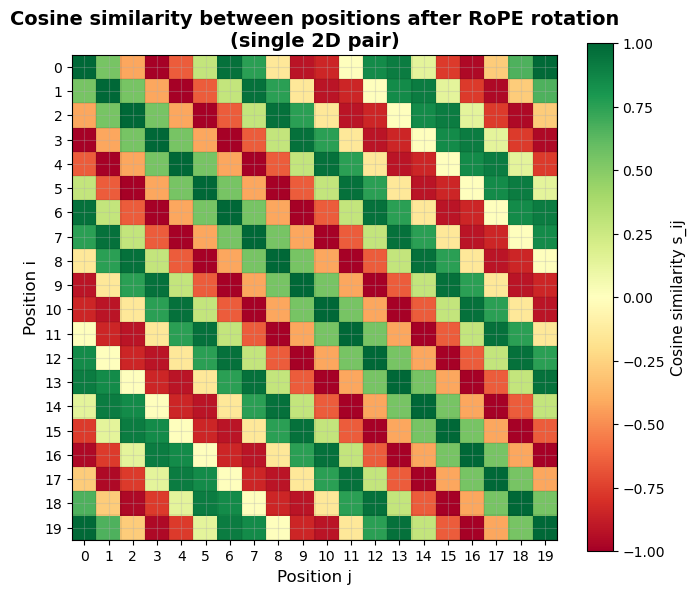

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def compute_rope_angles(num_positions=20, head_dim=32, base=10000.0):
    """
    Compute RoPE rotation angles θ_i(p) for all positions and 2D pairs.

    Parameters
    ----------
    num_positions : int
        Number of sequence positions (including CLS at 0).
    head_dim : int
        Head dimension (must be even).
    base : float
        RoPE base, usually 10000.0.

    Returns
    -------
    angles : np.ndarray
        Array of shape [num_positions, head_dim//2] with θ_i(p).
        angles[p, i] = θ_i(p) for position p and pair index i.
    """
    assert head_dim % 2 == 0, "head_dim must be even for RoPE."

    positions = np.arange(num_positions, dtype=np.float64)[:, None]  # [P, 1]
    pair_indices = np.arange(head_dim // 2, dtype=np.float64)[None, :]  # [1, D/2]

    # θ_i(p) = p / base^(2i/head_dim)
    exponents = 2.0 * pair_indices / head_dim  # [1, D/2]
    inv_freq = base ** (-exponents)           # [1, D/2]
    angles = positions * inv_freq             # [P, D/2]

    return angles


def rotate_2d(v, theta):
    """
    Apply 2D rotation R(θ) to vector v in R^2.

    R(θ) = [[cosθ, -sinθ],
            [sinθ,  cosθ]]
    """
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]], dtype=np.float64)
    return R @ v


def plot_2d_rotation(angles, pair_index=0):
    """
    Visualize RoPE rotation in a single 2D plane for a given pair index.

    Left: rotated vectors as arrows on the unit circle.
    Right: rotation angle θ_i(p) vs position p (optionally with a second pair).
    """
    num_positions = angles.shape[0]

    # Base vector in this 2D plane
    v_base = np.array([1.0, 0.0], dtype=np.float64)

    # Extract θ_i(p) for this pair
    theta_pair = angles[:, pair_index]  # [P]

    # Compute rotated vectors v_p = R(θ_i(p)) v
    rotated_vectors = np.stack([rotate_2d(v_base, th) for th in theta_pair], axis=0)  # [P, 2]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ------------------------------------------------------------------
    # Left subplot: RoPE rotation in 2D plane
    # ------------------------------------------------------------------
    ax0 = axes[0]
    ax0.set_title("RoPE rotation of a single 2D pair", fontsize=14, fontweight="bold")
    ax0.set_xlabel("Dimension 0", fontsize=12)
    ax0.set_ylabel("Dimension 1", fontsize=12)
    ax0.set_aspect("equal", "box")
    ax0.grid(True, alpha=0.3)

    # Draw unit circle for context
    circle_theta = np.linspace(0, 2 * np.pi, 512)
    ax0.plot(np.cos(circle_theta), np.sin(circle_theta), "k--", alpha=0.4, label="Unit circle")

    # Color positions from dark to bright
    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(0.0, 1.0, num_positions))

    # Plot rotated vectors as arrows from the origin
    for p in range(num_positions):
        vx, vy = rotated_vectors[p]
        ax0.arrow(
            0.0,
            0.0,
            vx,
            vy,
            head_width=0.05,
            head_length=0.08,
            fc=colors[p],
            ec=colors[p],
            length_includes_head=True,
            alpha=0.9,
        )

    # Annotate a few positions
    for p in [0, num_positions // 4, num_positions // 2, num_positions - 1]:
        vx, vy = rotated_vectors[p]
        ax0.text(vx * 1.05, vy * 1.05, f"{p}", color=colors[p], fontsize=9, ha="center", va="center")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_positions - 1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax0)
    cbar.set_label("Token position p", fontsize=11)
    # Force integer ticks 0..num_positions-1 on the colorbar
    cbar.set_ticks(np.arange(num_positions))

    ax0.legend(loc="upper right", fontsize=10)

    # ------------------------------------------------------------------
    # Right subplot: angle vs position
    # ------------------------------------------------------------------
    ax1 = axes[1]
    ax1.set_title("Rotation angle vs position", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Position p", fontsize=12)
    ax1.set_ylabel(r"Rotation angle $\theta_i(p)$ (radians)", fontsize=12)
    ax1.grid(True, alpha=0.3)

    positions = np.arange(num_positions)

    # Main pair (slow frequency)
    ax1.plot(positions, theta_pair, marker="o", label=f"Pair index {pair_index} (low frequency)")
    # Force integer ticks 0..num_positions-1 on the x-axis
    ax1.set_xticks(positions)

    # Optional: second, faster pair for comparison (e.g. pair 5)
    second_pair_index = min(5, angles.shape[1] - 1)
    if second_pair_index != pair_index:
        theta_pair_fast = angles[:, second_pair_index]
        ax1.plot(
            positions,
            theta_pair_fast,
            marker="s",
            linestyle="--",
            label=f"Pair index {second_pair_index} (higher frequency)",
        )

    ax1.legend(fontsize=10)

    plt.tight_layout()


def plot_similarity_heatmap(angles, pair_index=0):
    """
    Show cosine similarity between positions after RoPE rotation
    in a single 2D plane (relative-position effect).

    We use v_base = [1, 0], and v_p = R(θ_i(p)) v_base.

    s_ij = (v_i · v_j) / (||v_i|| ||v_j||)
    """
    num_positions = angles.shape[0]
    v_base = np.array([1.0, 0.0], dtype=np.float64)
    theta_pair = angles[:, pair_index]

    # Rotated vectors for each position
    rotated_vectors = np.stack([rotate_2d(v_base, th) for th in theta_pair], axis=0)  # [P, 2]

    # Normalize vectors
    norms = np.linalg.norm(rotated_vectors, axis=1, keepdims=True)  # [P, 1]
    norms = np.maximum(norms, 1e-12)
    v_norm = rotated_vectors / norms  # [P, 2]

    # Cosine similarities s_ij = v_i · v_j (since already normalized)
    sim_matrix = v_norm @ v_norm.T  # [P, P]

    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    im = ax.imshow(
        sim_matrix,
        cmap="RdYlGn",
        vmin=-1.0,
        vmax=1.0,
        interpolation="nearest",
        aspect="equal",
    )

    ax.set_title(
        "Cosine similarity between positions after RoPE rotation\n(single 2D pair)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xlabel("Position j", fontsize=12)
    ax.set_ylabel("Position i", fontsize=12)

    ticks = np.arange(num_positions)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Center grid lines between integer positions
    for t in np.arange(num_positions + 1) - 0.5:
        ax.axhline(t, color="k", linewidth=0.3, alpha=0.3)
        ax.axvline(t, color="k", linewidth=0.3, alpha=0.3)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Cosine similarity s_ij", fontsize=11)

    plt.tight_layout()


def main():
    head_dim = 32
    num_positions = 20  # includes CLS at position 0

    # ------------------------------------------------------------------
    # Compute RoPE angles
    # ------------------------------------------------------------------
    angles = compute_rope_angles(num_positions=num_positions, head_dim=head_dim, base=10000.0)

    # ------------------------------------------------------------------
    # Figure 1: 2D rotation intuition + angle vs position
    # ------------------------------------------------------------------
    plot_2d_rotation(angles, pair_index=0)

    # ------------------------------------------------------------------
    # Figure 2 (optional but nice): similarity heatmap
    # ------------------------------------------------------------------
    plot_similarity_heatmap(angles, pair_index=0)

    plt.show()


if __name__ == "__main__":
    main()

## 3. Extract Layer-by-Layer Representations

Use forward hooks to capture intermediate representations at each stage:
1. After embedding (before positional encoding)
2. After positional encoding is added
3. After each transformer encoder block

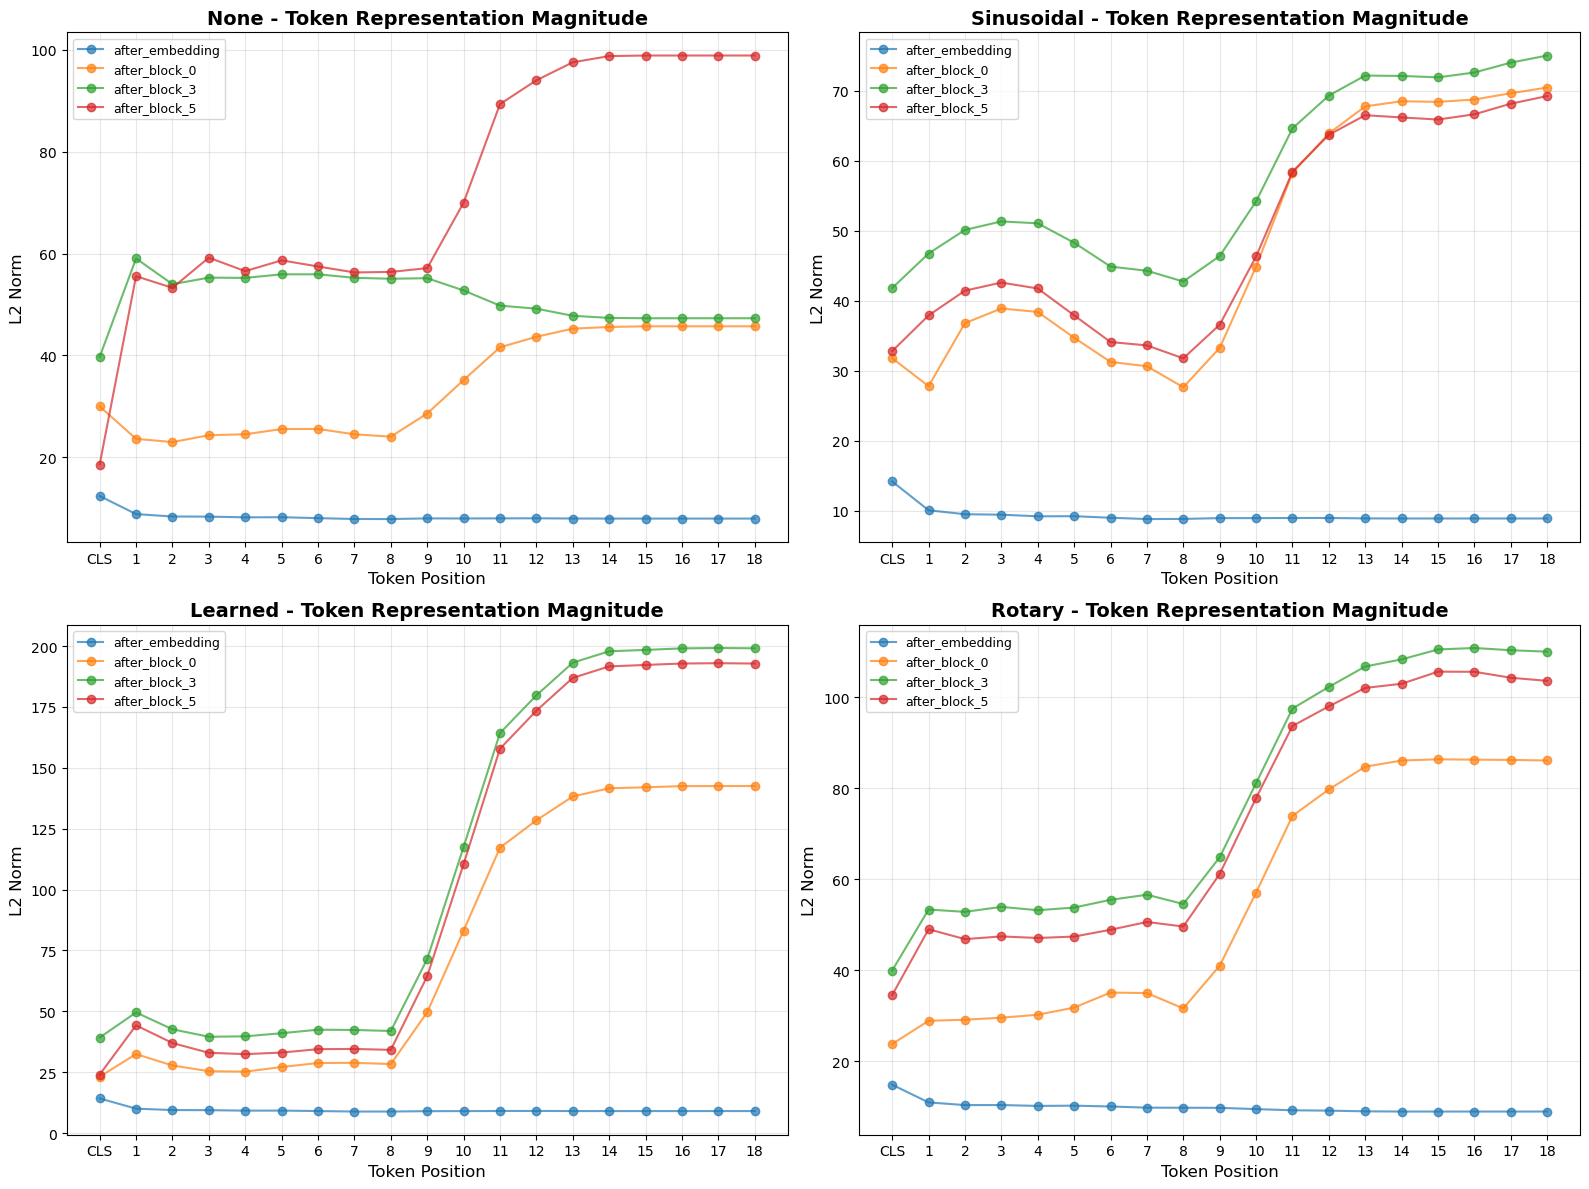

In [ ]:
# Plot L2 norms with explicit token labels (CLS, 1..18) - robust

import matplotlib.pyplot as plt
import numpy as np
import torch


def _compute_l2_from_reprs(representations_dict):
    out = {}
    for pe_type, layers in representations_dict.items():
        out[pe_type] = {}
        for name, tensor in layers.items():
            # tensor: [B, T, D]
            l2 = torch.norm(tensor, p=2, dim=-1)          # [B, T]
            out[pe_type][name] = l2.mean(dim=0).numpy()   # [T]
    return out

# Ensure l2_norms exists as a dict; else recompute from `representations`
try:
    has_l2 = isinstance(l2_norms, dict)
except NameError:
    has_l2 = False

if not has_l2:
    try:
        l2_norms = _compute_l2_from_reprs(representations)
    except NameError:
        raise RuntimeError("Need l2_norms or representations in scope. Run the extraction cell first.") from None

# Build the figure
sample_pe = next(iter(l2_norms.keys()))
num_blocks = len([k for k in l2_norms[sample_pe] if 'block' in k])

layers_to_plot = ['after_embedding']
if 'after_pos_enc' in l2_norms[sample_pe]:
    layers_to_plot.append('after_pos_enc')
layers_to_plot.extend(['after_block_0', f'after_block_{num_blocks//2}', f'after_block_{num_blocks-1}'])

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

pe_types_ordered = ['none', 'sinusoidal', 'learned', 'rotary']
pe_types_available = [pt for pt in pe_types_ordered if pt in l2_norms]

for idx, pe_type in enumerate(pe_types_available):
    ax = axes[idx]
    num_tokens = None

    for layer_name in layers_to_plot:
        if layer_name in l2_norms[pe_type]:
            norms = l2_norms[pe_type][layer_name]
            if num_tokens is None:
                num_tokens = len(norms)
            ax.plot(norms, label=layer_name, marker='o', alpha=0.7)

    # X-axis: CLS, 1..18
    if num_tokens is not None:
        positions = np.arange(num_tokens)
        ax.set_xticks(positions)
        ax.set_xticklabels(['CLS'] + [str(i) for i in range(1, num_tokens)])

    ax.set_xlabel('Token Position', fontsize=12)
    ax.set_ylabel('L2 Norm', fontsize=12)
    ax.set_title(f'{pe_type.capitalize()} - Token Representation Magnitude', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(pe_types_available), 4):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Hook storage
class ActivationCapture:
    """Capture intermediate activations during forward pass."""
    
    def __init__(self):
        self.activations = {}
        self.hooks = []
    
    def register_hook(self, module, name):
        """Register a forward hook on a module."""
        def hook(module, input, output):
            # Handle different output types
            if isinstance(output, tuple):
                # Some modules return (output, attention_weights)
                self.activations[name] = output[0].detach().cpu()
            else:
                self.activations[name] = output.detach().cpu()
        
        handle = module.register_forward_hook(hook)
        self.hooks.append(handle)
    
    def clear(self):
        """Clear stored activations."""
        self.activations = {}
    
    def remove_hooks(self):
        """Remove all registered hooks."""
        for handle in self.hooks:
            handle.remove()
        self.hooks = []

print("✓ ActivationCapture class defined")

✓ ActivationCapture class defined


In [11]:
# Function to extract representations from all models
def extract_layer_representations(models_info, data_loader, num_batches=1):
    """Extract layer-by-layer representations from all models.
    
    Parameters
    ----------
    models_info : dict
        Dictionary mapping PE type to model info
    data_loader : DataLoader
        DataLoader to get samples from
    num_batches : int
        Number of batches to process
    
    Returns
    -------
    dict
        Nested dict: {pe_type: {layer_name: tensor [B, T, D]}}
    """
    all_representations = {}
    all_labels = {}
    
    for pe_type, info in models_info.items():
        model = info["model"]
        device = info["device"]
        model.eval()
        
        # Create activation capture
        capture = ActivationCapture()
        
        # Register hooks on key modules
        capture.register_hook(model.embedding, "after_embedding")
        
        # Only register pos_enc hook if it exists and is not rotary
        if model.pos_enc is not None and pe_type not in ["none", "rotary"]:
            capture.register_hook(model.pos_enc, "after_pos_enc")
        
        # Register hooks on each encoder block
        for block_idx, block in enumerate(model.encoder.blocks):
            capture.register_hook(block, f"after_block_{block_idx}")
        
        # Initialize batch_activations with all possible keys
        possible_keys = ["after_embedding"]
        if model.pos_enc is not None and pe_type not in ["none", "rotary"]:
            possible_keys.append("after_pos_enc")
        possible_keys.extend([f"after_block_{i}" for i in range(len(model.encoder.blocks))])
        
        batch_activations = {key: [] for key in possible_keys}
        batch_labels = []
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(data_loader):
                if batch_idx >= num_batches:
                    break
                
                # Unpack batch - handle different formats
                if len(batch) == 4:  # Raw format: (tokens_cont, tokens_id, labels, mask)
                    tokens_cont, tokens_id, labels, mask = batch
                    tokens_cont = tokens_cont.to(device)
                    tokens_id = tokens_id.to(device)
                    mask = mask.to(device)
                    _ = model(tokens_cont, tokens_id, mask=mask)
                elif len(batch) == 5:  # Raw format with globals: (tokens_cont, tokens_id, globals, mask, labels)
                    tokens_cont, tokens_id, globals, mask, labels = batch
                    tokens_cont = tokens_cont.to(device)
                    tokens_id = tokens_id.to(device)
                    mask = mask.to(device)
                    _ = model(tokens_cont, tokens_id, mask=mask)
                else:  # Binned format: (tokens, labels, mask) or (tokens, globals, mask, labels)
                    if len(batch) == 3:
                        tokens, labels, mask = batch
                        tokens = tokens.to(device)
                        mask = mask.to(device)
                        _ = model(tokens, mask=mask)
                    else:
                        tokens, globals, mask, labels = batch
                        tokens = tokens.to(device)
                        mask = mask.to(device)
                        _ = model(tokens, mask=mask)
                
                # Store activations
                for key in capture.activations:
                    if key in batch_activations:
                        batch_activations[key].append(capture.activations[key])
                
                batch_labels.append(labels.cpu())
                capture.clear()
        
        # Concatenate batches
        representations = {}
        for key, act_list in batch_activations.items():
            if len(act_list) > 0:
                representations[key] = torch.cat(act_list, dim=0)
        
        all_representations[pe_type] = representations
        all_labels[pe_type] = torch.cat(batch_labels, dim=0)
        
        # Clean up hooks
        capture.remove_hooks()
        
        print(f"✓ Extracted representations for {pe_type}")
        print(f"  Layers captured: {list(representations.keys())}")
    
    return all_representations, all_labels

print("✓ Extraction function defined")

✓ Extraction function defined


In [12]:
# Extract representations from validation set
print("Extracting layer-by-layer representations...")
print("This may take a minute...\n")

representations, labels = extract_layer_representations(models_info, val_dl, num_batches=5)

print("\n✓ Extraction complete!")
print(f"\nModels analyzed: {list(representations.keys())}")
print(f"Sample counts per model: {labels[list(labels.keys())[0]].shape[0]}")

# Display shape information
sample_pe_type = list(representations.keys())[0]
print(f"\nExample shapes for '{sample_pe_type}':")
for layer_name, tensor in representations[sample_pe_type].items():
    print(f"  {layer_name}: {tensor.shape} [batch, tokens, dim]")

Extracting layer-by-layer representations...
This may take a minute...

✓ Extracted representations for none
  Layers captured: ['after_embedding', 'after_block_0', 'after_block_1', 'after_block_2', 'after_block_3', 'after_block_4', 'after_block_5']
✓ Extracted representations for sinusoidal
  Layers captured: ['after_embedding', 'after_pos_enc', 'after_block_0', 'after_block_1', 'after_block_2', 'after_block_3', 'after_block_4', 'after_block_5']
✓ Extracted representations for learned
  Layers captured: ['after_embedding', 'after_pos_enc', 'after_block_0', 'after_block_1', 'after_block_2', 'after_block_3', 'after_block_4', 'after_block_5']
✓ Extracted representations for rotary
  Layers captured: ['after_embedding', 'after_block_0', 'after_block_1', 'after_block_2', 'after_block_3', 'after_block_4', 'after_block_5']

✓ Extraction complete!

Models analyzed: ['none', 'sinusoidal', 'learned', 'rotary']
Sample counts per model: 320

Example shapes for 'none':
  after_embedding: torch.Siz

## 4. Visualize Representations in Model Dimensions

Analyze how representations evolve through the network by looking at:
- Token-wise L2 norms (representation magnitude)
- Pairwise token similarities (cosine similarity)
- How these differ across positional encoding types

In [27]:
# Compute pairwise token similarity matrices
def compute_similarity_matrix(tensor):
    """Compute cosine similarity between all token pairs.
    
    Parameters
    ----------
    tensor : torch.Tensor
        Shape [B, T, D]
    
    Returns
    -------
    np.ndarray
        Similarity matrix [T, T] averaged over batch
    """
    # Average over batch
    token_vecs = tensor.mean(dim=0)  # [T, D]
    
    # Compute cosine similarity
    from torch.nn.functional import cosine_similarity
    
    T = token_vecs.shape[0]
    sim_matrix = np.zeros((T, T))
    
    for i in range(T):
        for j in range(T):
            if i == j:
                sim_matrix[i, j] = 1.0
            else:
                sim = cosine_similarity(
                    token_vecs[i:i+1], 
                    token_vecs[j:j+1], 
                    dim=1
                ).item()
                sim_matrix[i, j] = sim
    
    return sim_matrix

print("✓ Similarity computation function defined")

✓ Similarity computation function defined


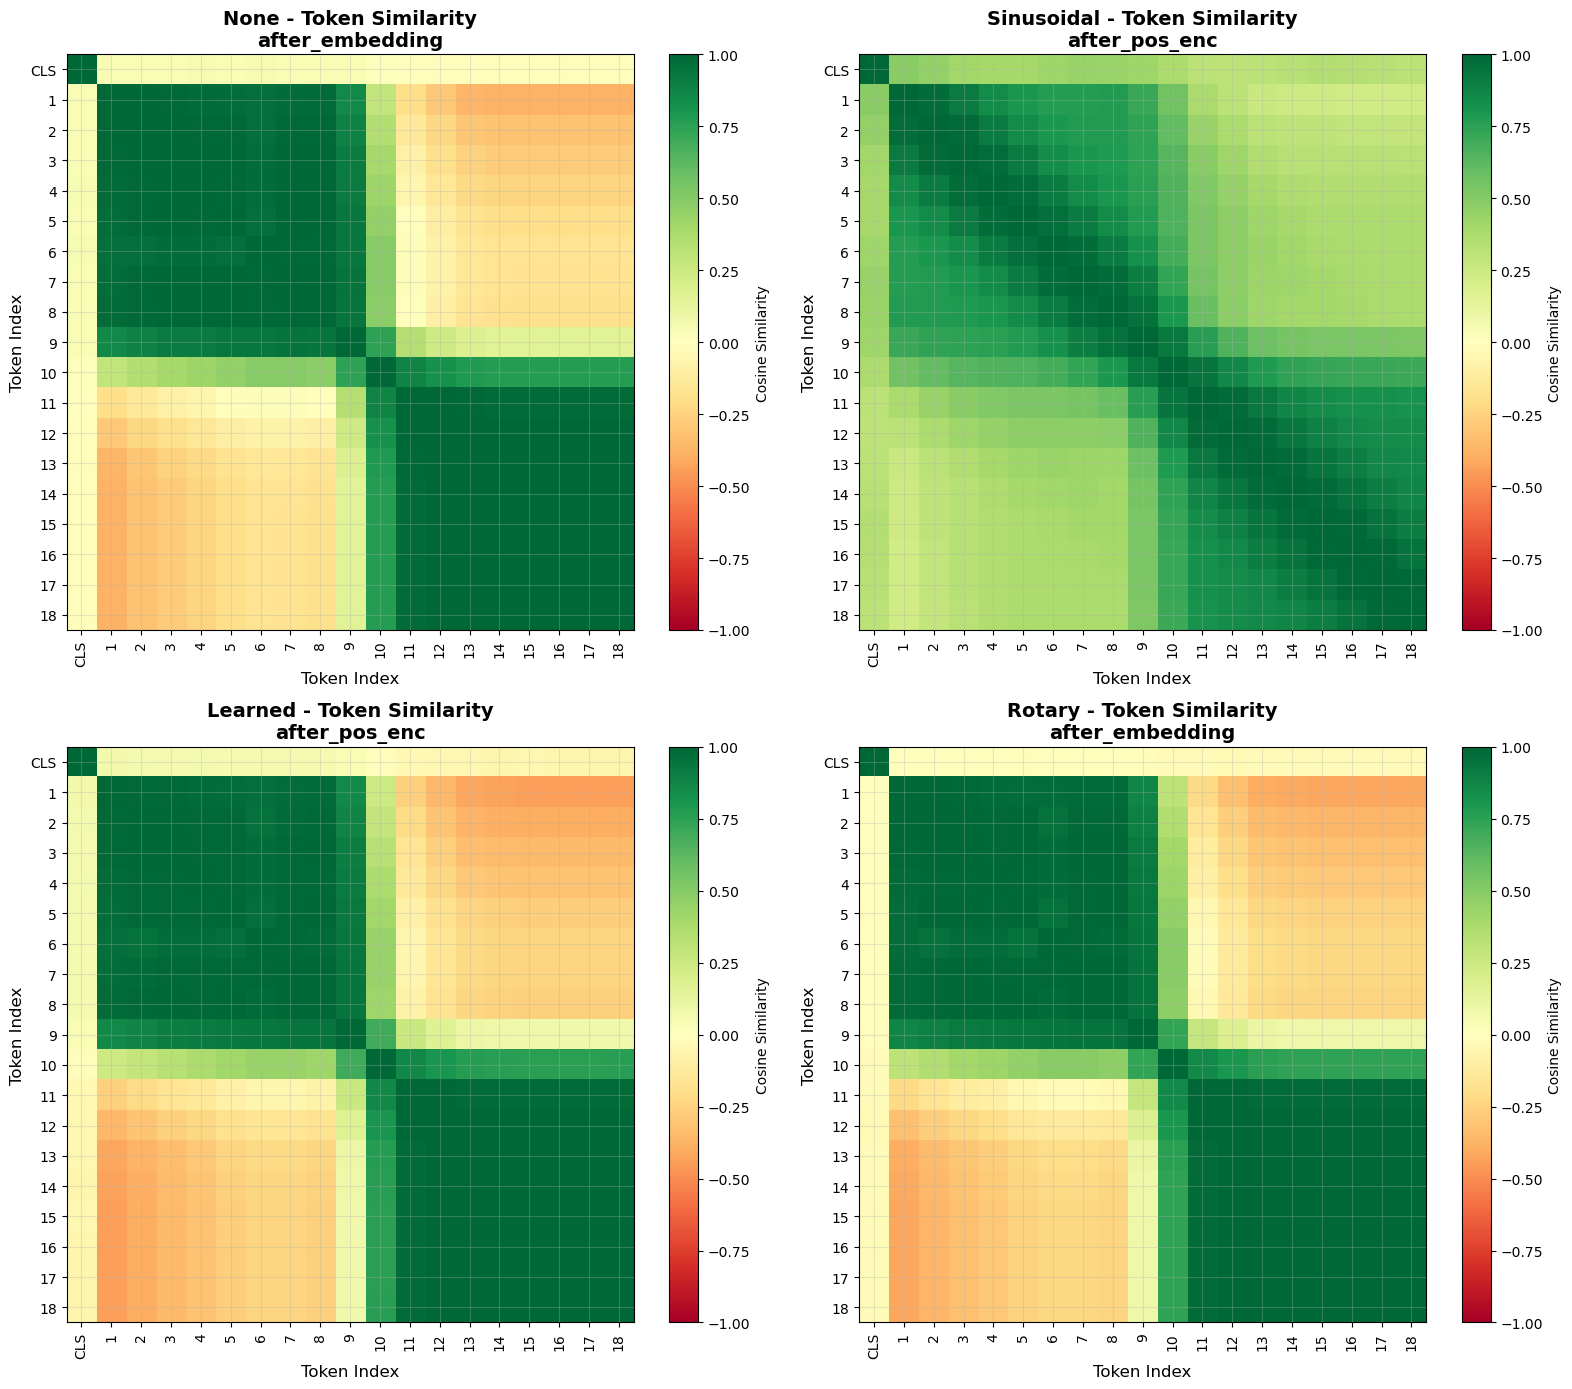


Key Observations:
- Diagonal is always 1.0 (token similarity with itself)
- Off-diagonal patterns show how PE creates token differentiation
- 'None' should show more uniform similarity (less position info)
- Sinusoidal/Learned/Rotary should show position-dependent patterns


In [ ]:
# Visualize similarity matrices at key layers
# Compare after positional encoding is added

# Ensure pe_types_available is defined
pe_types_ordered = ['none', 'sinusoidal', 'learned', 'rotary']
pe_types_available = [pt for pt in pe_types_ordered if pt in representations]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

layer_to_compare = 'after_pos_enc'  # or 'after_embedding' if no pos_enc

for idx, pe_type in enumerate(pe_types_available):
    ax = axes[idx]
    
    # Find appropriate layer
    if layer_to_compare in representations[pe_type]:
        layer_tensor = representations[pe_type][layer_to_compare]
        actual_layer = layer_to_compare
    elif 'after_embedding' in representations[pe_type]:
        layer_tensor = representations[pe_type]['after_embedding']
        actual_layer = 'after_embedding'
    else:
        ax.text(0.5, 0.5, f'{pe_type}\nNo data', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Compute similarity matrix
    sim_matrix = compute_similarity_matrix(layer_tensor)
    
    # Plot
    im = ax.imshow(sim_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
    ax.set_xlabel('Token Index', fontsize=12)
    ax.set_ylabel('Token Index', fontsize=12)
    ax.set_title(f'{pe_type.capitalize()} - Token Similarity\n{actual_layer}', 
                 fontsize=14, fontweight='bold')

    # Set axis ticks/labels: CLS, then tokens 1..18 (clip if fewer)
    num_tokens = sim_matrix.shape[0]
    desired_labels = ['CLS'] + [str(i) for i in range(1, 19)]
    positions = np.arange(min(num_tokens, len(desired_labels)))
    ax.set_xticks(positions)
    ax.set_yticks(positions)
    ax.set_xticklabels(desired_labels[:len(positions)], rotation=90)
    ax.set_yticklabels(desired_labels[:len(positions)])

    plt.colorbar(im, ax=ax, label='Cosine Similarity')

# Hide unused subplots
for idx in range(len(pe_types_available), 4):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



In [34]:
import h5py
import numpy as np

# uses the same dataset path as this notebook (data_path defined earlier)
with h5py.File(data_path, "r") as f:
    X = f["X_val"]  # validation split used above
    event_idx = 0   # same first event as used when iterating val_dl
    evt = X[event_idx][:]

    print(f"Event #{event_idx} in X_val")
    print("Full event (92 values):")
    print(evt)

Event #0 in X_val
Full event (92 values):
[ 1.         1.         2.         1.         2.         1.
  5.         5.         4.         3.         0.         0.
  0.         0.         0.         0.         0.         0.
 10.587732  -2.15792   13.254089  13.048516  -0.634781   0.218962
 12.49723   12.442369  -0.333986  -1.57811   12.209816  12.026312
 -0.619121  -2.71786   12.196643  11.94072    0.738242   1.17841
 12.092187  11.747555  -0.851529  -0.432547  11.607754  11.604693
 -0.050921   1.45162   12.641795  12.6090145  0.257455   2.88122
 11.479565  11.46604    0.164844  -2.57352   11.470918  11.196382
  0.775317   2.586      9.599642   9.558198   0.289876   2.90321
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

## 5. Dimensionality Reduction: PCA and t-SNE

Project high-dimensional representations to 2D/3D to visualize:
- Class separability (4t vs background)
- How separation emerges through layers
- Differences between positional encoding strategies

In [17]:
# Import dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("✓ Dimensionality reduction imports loaded")

✓ Dimensionality reduction imports loaded


In [18]:
# Prepare data for dimensionality reduction
def prepare_for_reduction(tensor, pooling='mean'):
    """
    Prepare tensor for dimensionality reduction.
    
    Parameters
    ----------
    tensor : torch.Tensor
        Shape [B, T, D]
    pooling : str
        'mean' or 'cls' (use first token)
    
    Returns
    -------
    np.ndarray
        Shape [B, D]
    """
    if pooling == 'mean':
        # Average over tokens
        pooled = tensor.mean(dim=1)  # [B, D]
    elif pooling == 'cls':
        # Use first token (CLS)
        pooled = tensor[:, 0, :]  # [B, D]
    else:
        raise ValueError(f"Unknown pooling: {pooling}")
    
    return pooled.numpy()

print("✓ Data preparation function defined")

✓ Data preparation function defined


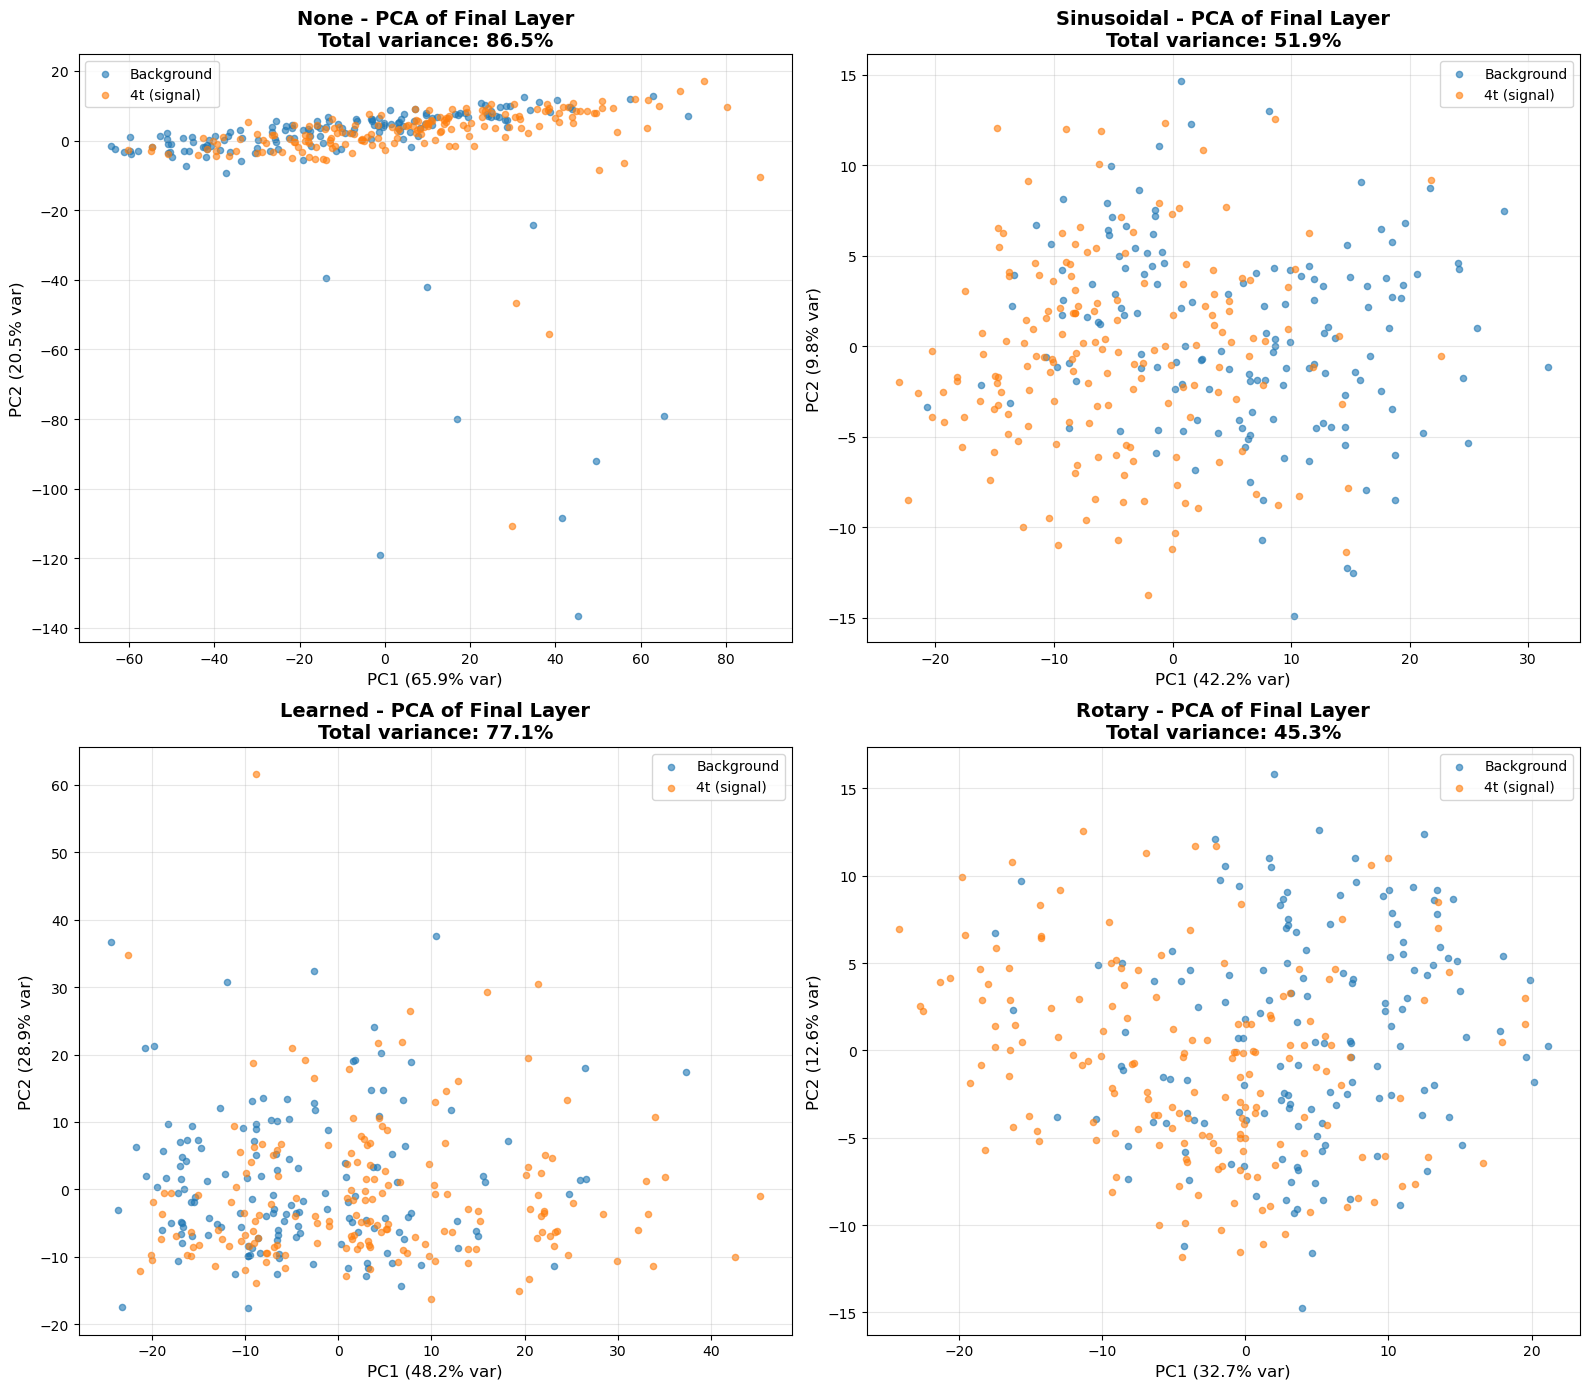


PCA shows linear separability of classes
Better separation = easier classification task


In [19]:
# PCA visualization - compare final layer across all PE types

# Ensure pe_types_available and num_blocks are defined
pe_types_ordered = ['none', 'sinusoidal', 'learned', 'rotary']
pe_types_available = [pt for pt in pe_types_ordered if pt in representations]

# Determine num_blocks from first available model
if pe_types_available:
    sample_pe = pe_types_available[0]
    num_blocks = len([k for k in representations[sample_pe] if 'block' in k])
    final_layer = f'after_block_{num_blocks-1}'
else:
    final_layer = 'after_block_0'  # fallback

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, pe_type in enumerate(pe_types_available):
    ax = axes[idx]
    
    if final_layer in representations[pe_type]:
        # Get final layer representations
        tensor = representations[pe_type][final_layer]
        X = prepare_for_reduction(tensor, pooling='mean')
        y = labels[pe_type].numpy()
        
        # Apply PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        # Plot by class
        for class_idx in [0, 1]:
            mask = y == class_idx
            class_name = '4t (signal)' if class_idx == 1 else 'Background'
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      label=class_name, alpha=0.6, s=20)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
        ax.set_title(f'{pe_type.capitalize()} - PCA of Final Layer\nTotal variance: {pca.explained_variance_ratio_[:2].sum():.1%}', 
                     fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{pe_type}\nNo data', 
                ha='center', va='center', transform=ax.transAxes)

# Hide unused subplots
for idx in range(len(pe_types_available), 4):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nPCA shows linear separability of classes")
print("Better separation = easier classification task")

Computing t-SNE (this may take a minute)...
  Processing none...
  Processing sinusoidal...
  Processing learned...
  Processing rotary...


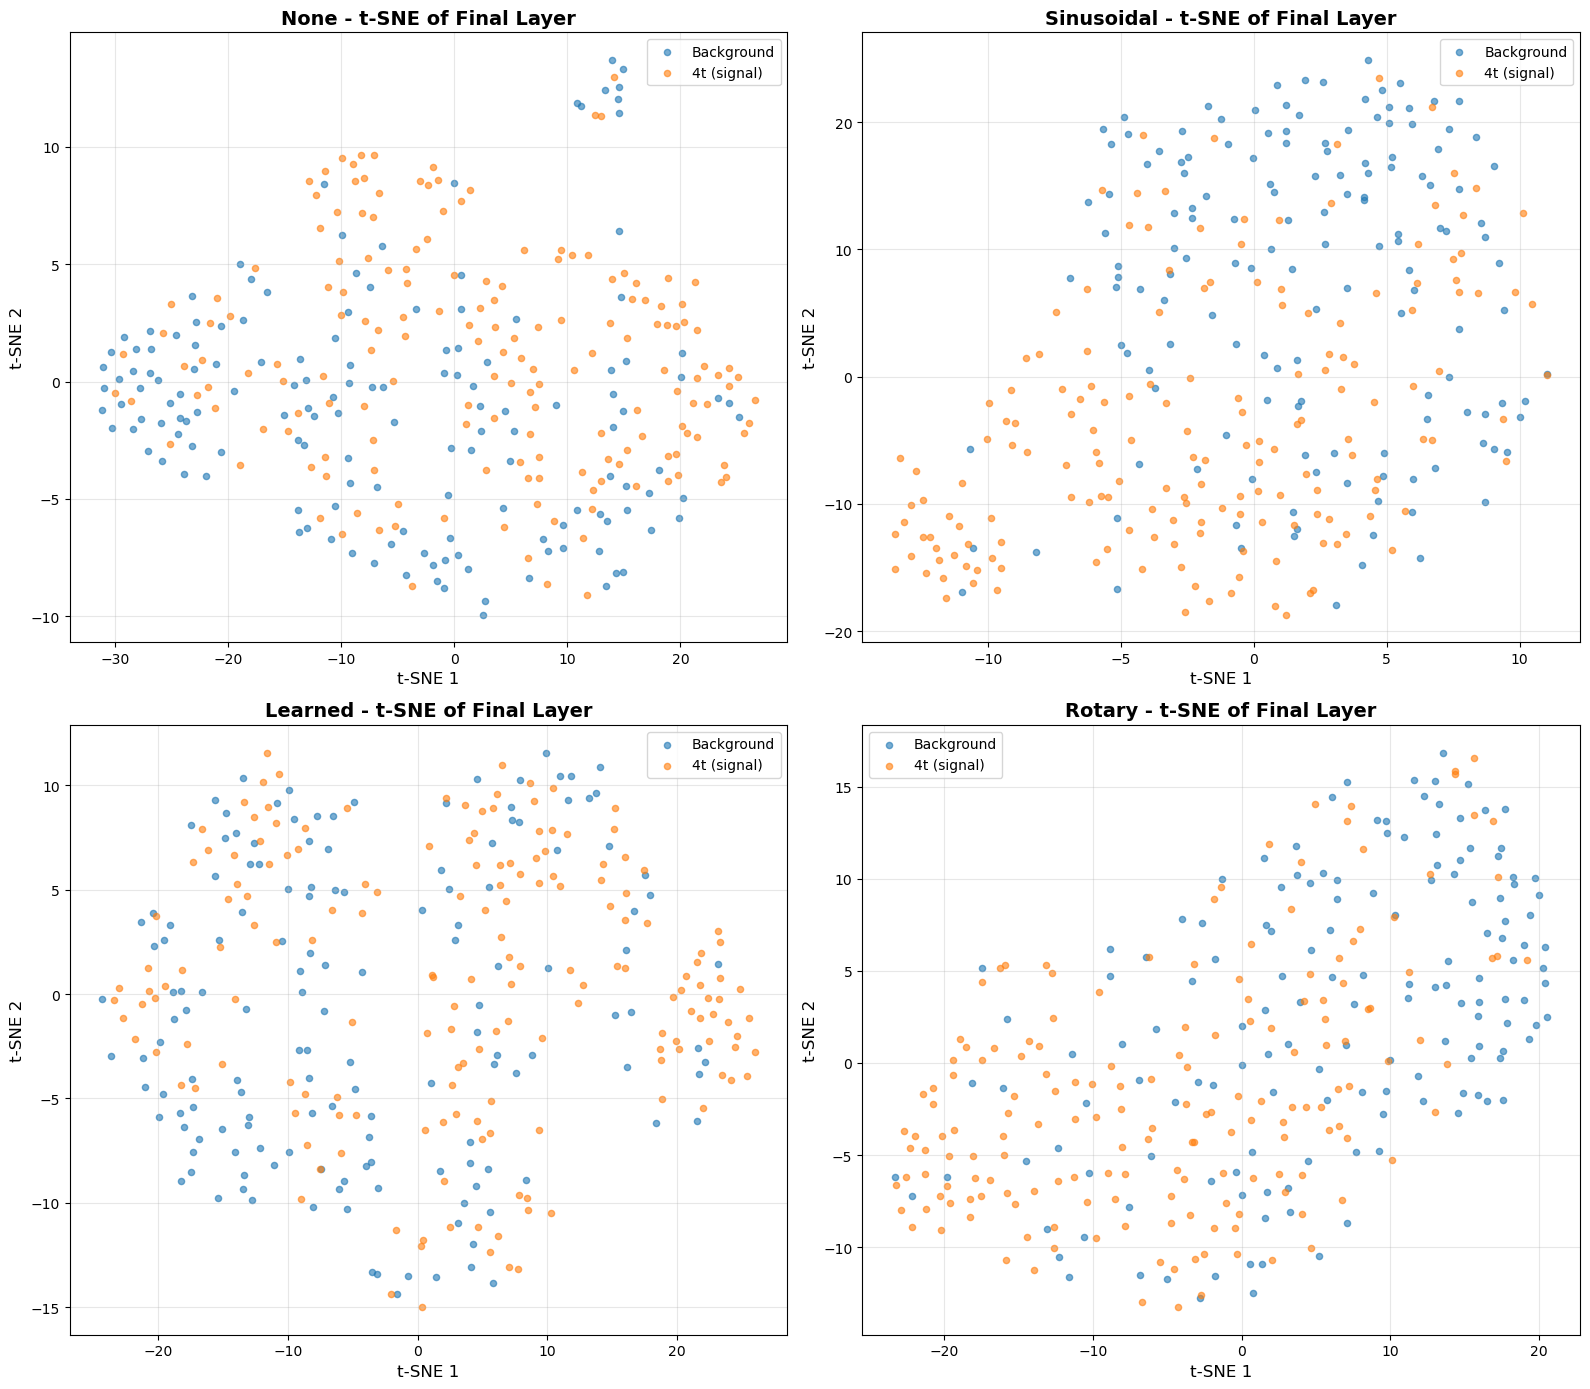


✓ t-SNE complete
t-SNE reveals local clustering structure
Well-separated clusters indicate better learned representations


In [20]:
# t-SNE visualization - focuses on local structure
print("Computing t-SNE (this may take a minute)...")

# Ensure pe_types_available and final_layer are defined
pe_types_ordered = ['none', 'sinusoidal', 'learned', 'rotary']
pe_types_available = [pt for pt in pe_types_ordered if pt in representations]

# Determine num_blocks and final_layer
if pe_types_available:
    sample_pe = pe_types_available[0]
    num_blocks = len([k for k in representations[sample_pe] if 'block' in k])
    final_layer = f'after_block_{num_blocks-1}'
else:
    final_layer = 'after_block_0'  # fallback

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, pe_type in enumerate(pe_types_available):
    print(f"  Processing {pe_type}...")
    ax = axes[idx]
    
    if final_layer in representations[pe_type]:
        # Get final layer representations
        tensor = representations[pe_type][final_layer]
        X = prepare_for_reduction(tensor, pooling='mean')
        y = labels[pe_type].numpy()
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
        X_tsne = tsne.fit_transform(X)
        
        # Plot by class
        for class_idx in [0, 1]:
            mask = y == class_idx
            class_name = '4t (signal)' if class_idx == 1 else 'Background'
            ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                      label=class_name, alpha=0.6, s=20)
        
        ax.set_xlabel('t-SNE 1', fontsize=12)
        ax.set_ylabel('t-SNE 2', fontsize=12)
        ax.set_title(f'{pe_type.capitalize()} - t-SNE of Final Layer', 
                     fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{pe_type}\nNo data', 
                ha='center', va='center', transform=ax.transAxes)

# Hide unused subplots
for idx in range(len(pe_types_available), 4):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ t-SNE complete")
print("t-SNE reveals local clustering structure")
print("Well-separated clusters indicate better learned representations")

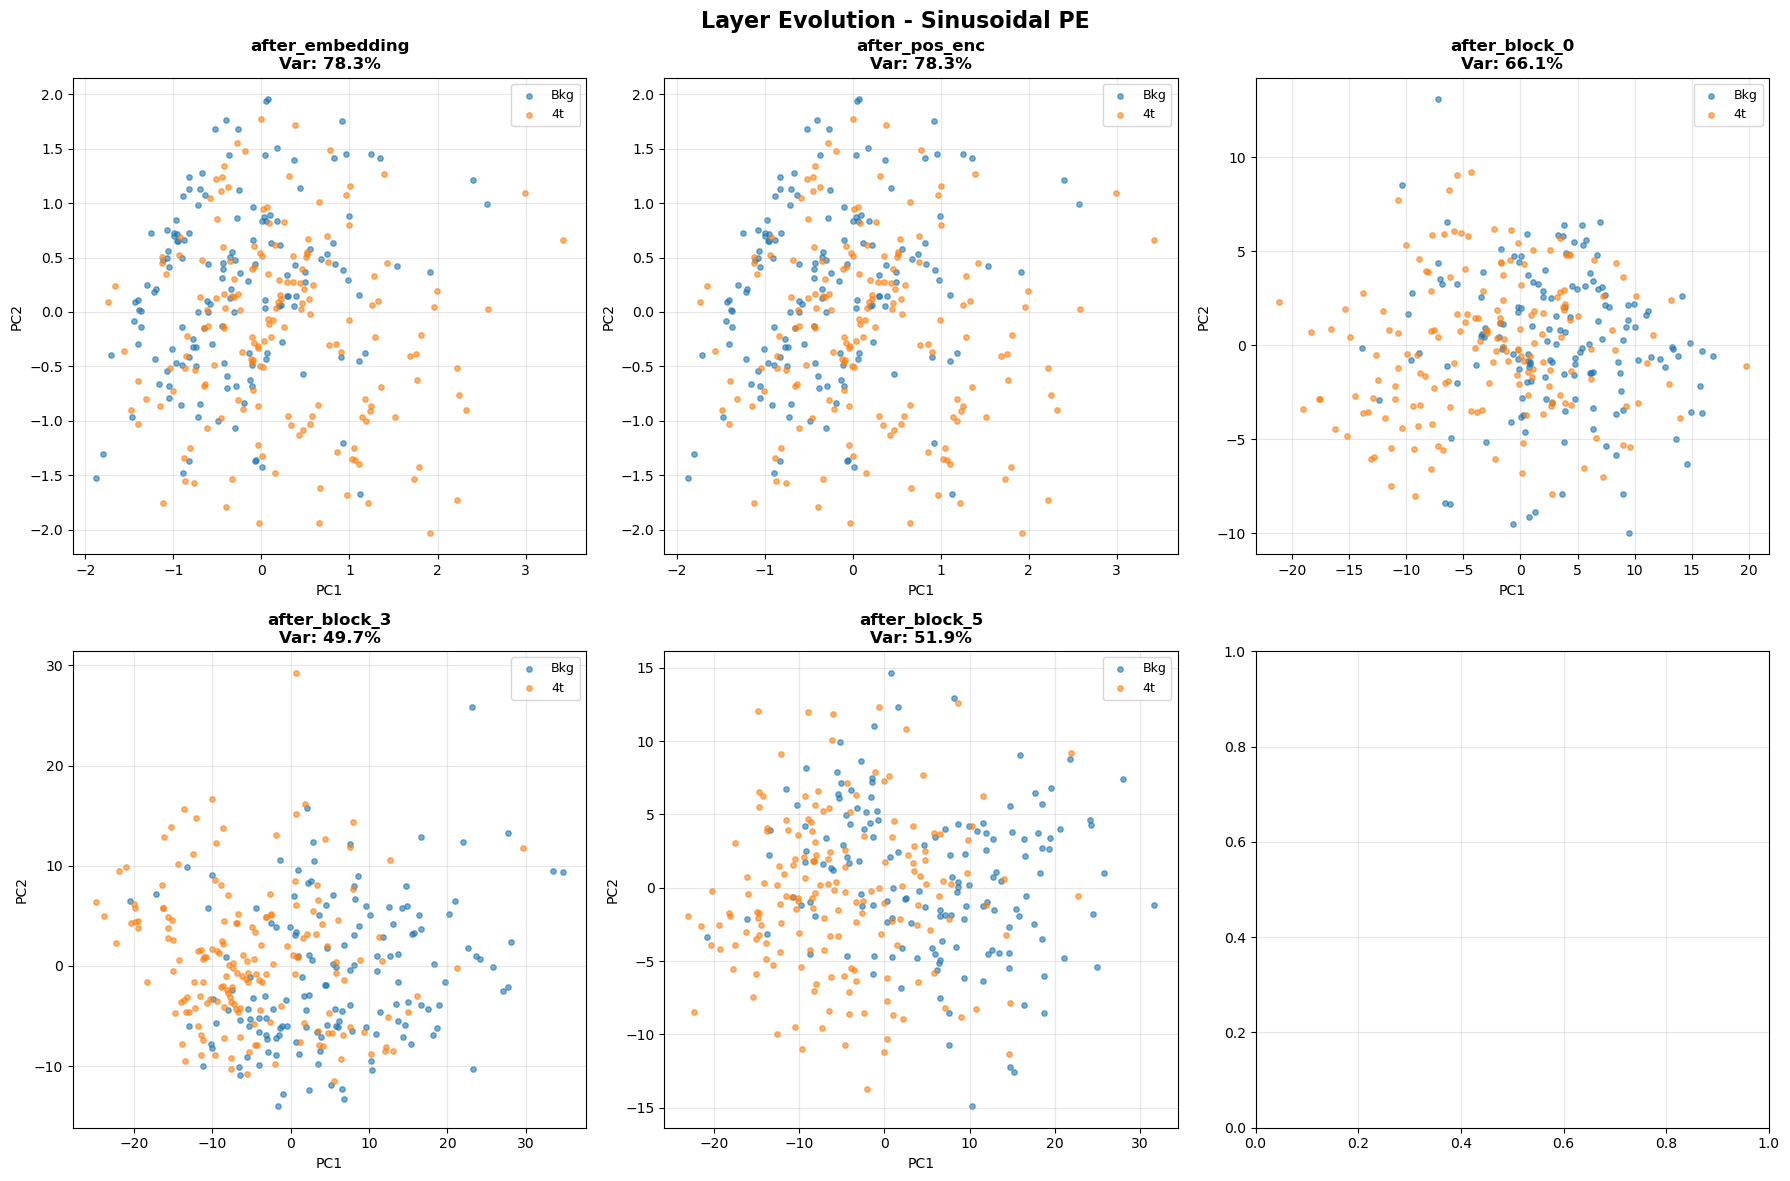


Showing how class separation evolves through layers for sinusoidal
Watch how the two classes become more separable in deeper layers


In [21]:
# Evolution through layers - show how PCA separation improves
# Pick one PE type to show layer evolution

# Ensure pe_types_available and num_blocks are defined
pe_types_ordered = ['none', 'sinusoidal', 'learned', 'rotary']
pe_types_available = [pt for pt in pe_types_ordered if pt in representations]

if not pe_types_available:
    print("No models available for layer evolution visualization")
else:
    pe_for_evolution = 'sinusoidal' if 'sinusoidal' in representations else pe_types_available[0]
    
    # Determine num_blocks
    num_blocks = len([k for k in representations[pe_for_evolution] if 'block' in k])
    
    # Select layers to show evolution
    evolution_layers = ['after_embedding']
    if 'after_pos_enc' in representations[pe_for_evolution]:
        evolution_layers.append('after_pos_enc')
    evolution_layers.extend([f'after_block_{i}' for i in [0, num_blocks//2, num_blocks-1]])
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, layer_name in enumerate(evolution_layers[:6]):  # Max 6 subplots
        ax = axes[idx]
        
        if layer_name in representations[pe_for_evolution]:
            tensor = representations[pe_for_evolution][layer_name]
            X = prepare_for_reduction(tensor, pooling='mean')
            y = labels[pe_for_evolution].numpy()
            
            # Apply PCA
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            
            # Plot by class
            for class_idx in [0, 1]:
                mask = y == class_idx
                class_name = '4t' if class_idx == 1 else 'Bkg'
                ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                          label=class_name, alpha=0.6, s=15)
            
            var_explained = pca.explained_variance_ratio_[:2].sum()
            ax.set_xlabel('PC1', fontsize=10)
            ax.set_ylabel('PC2', fontsize=10)
            ax.set_title(f'{layer_name}\nVar: {var_explained:.1%}', fontsize=12, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        else:
            ax.axis('off')
    
    plt.suptitle(f'Layer Evolution - {pe_for_evolution.capitalize()} PE', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing how class separation evolves through layers for {pe_for_evolution}")
    print("Watch how the two classes become more separable in deeper layers")

## 6. Performance Comparison

Run inference on all models and compare their classification performance to quantify why positional encoding matters.

In [22]:
# Run inference on all models
from thesis_ml.reports.inference.classification import run_classification_inference

print("Running inference on all models...")
print("This will compute predictions and metrics on the test set.\n")

# Prepare models list
models_list = []
for _pe_type, info in models_info.items():
    models_list.append((info['run_id'], info['cfg'], info['model']))

# Run inference
try:
    inference_results = run_classification_inference(
        models=models_list,
        dataset_cfg=sample_cfg,
        split="test",
        inference_cfg={
            "batch_size": 512,
            "autocast": False,
            "seed": 42,
            "max_samples": None,
        }
    )
    
    print("\n✓ Inference complete!")
    print(f"Models evaluated: {list(inference_results.keys())}")
except Exception as e:
    print(f"\n✗ Inference failed: {e}")
    import traceback
    traceback.print_exc()
    inference_results = {}

Running inference on all models...
This will compute predictions and metrics on the test set.


✓ Inference complete!
Models evaluated: ['run_20251127-162910_4t_vs_background_positional_job0', 'run_20251127-162910_4t_vs_background_positional_job1', 'run_20251127-162910_4t_vs_background_positional_job2', 'run_20251127-162910_4t_vs_background_positional_job3']


In [23]:
# Create performance metrics table
import pandas as pd

if inference_results:
    metrics_data = []
    
    for run_id, metrics in inference_results.items():
        # Find corresponding PE type
        pe_type = None
        for pt, info in models_info.items():
            if info['run_id'] == run_id:
                pe_type = pt
                break
        
        if pe_type and isinstance(metrics, dict):
            metrics_data.append({
                'Positional Encoding': pe_type.capitalize(),
                'Accuracy': f"{metrics.get('accuracy', 0.0):.4f}",
                'Precision': f"{metrics.get('precision', 0.0):.4f}",
                'Recall': f"{metrics.get('recall', 0.0):.4f}",
                'F1': f"{metrics.get('f1', 0.0):.4f}",
                'AUROC': f"{metrics.get('auroc', 0.0):.4f}",
            })
    
    if metrics_data:
        metrics_df = pd.DataFrame(metrics_data)
        metrics_df = metrics_df.sort_values('AUROC', ascending=False)
        
        print("\n" + "="*80)
        print("PERFORMANCE COMPARISON - 4t vs Background Classification")
        print("="*80)
        print(metrics_df.to_string(index=False))
        print("="*80)
        
        # Highlight best performance
        best_pe = metrics_df.iloc[0]['Positional Encoding']
        best_auroc = metrics_df.iloc[0]['AUROC']
        print(f"\n🏆 Best performing: {best_pe} (AUROC: {best_auroc})")
    else:
        print("No metrics data available")
else:
    print("No inference results available. Please run inference first.")


PERFORMANCE COMPARISON - 4t vs Background Classification
Positional Encoding Accuracy Precision Recall     F1  AUROC
             Rotary   0.7258    0.0000 0.0000 0.0000 0.7999
               None   0.6780    0.0000 0.0000 0.0000 0.7420
         Sinusoidal   0.6297    0.0000 0.0000 0.0000 0.7016
            Learned   0.5432    0.0000 0.0000 0.0000 0.5625

🏆 Best performing: Rotary (AUROC: 0.7999)


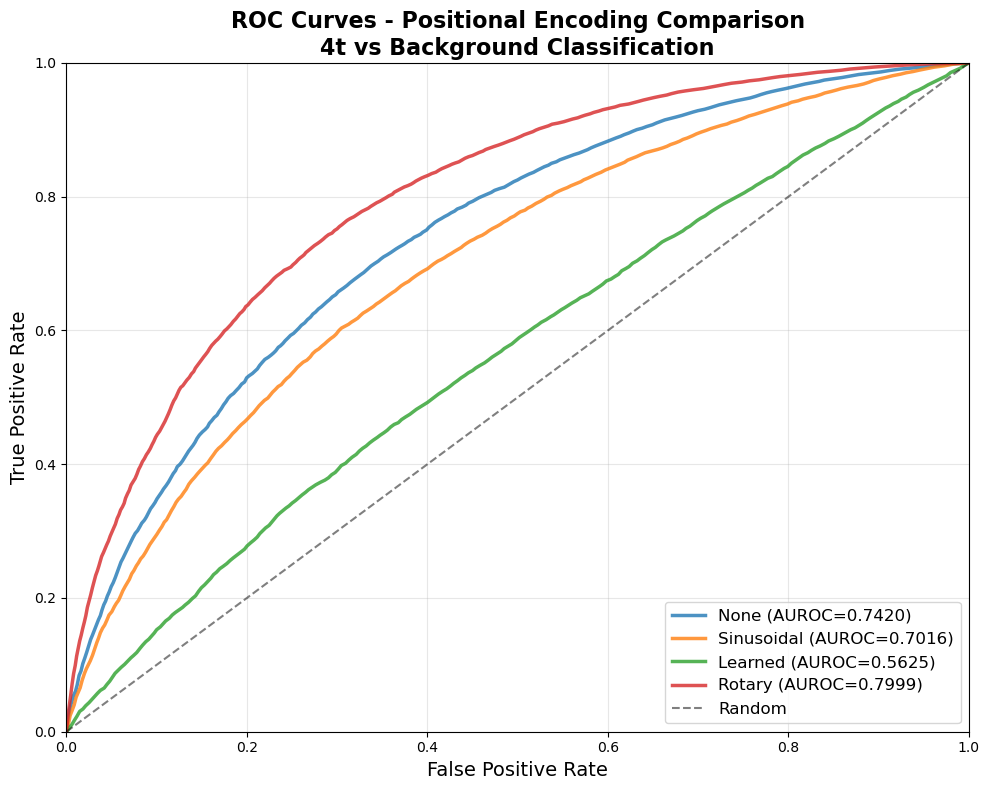


ROC curves show the trade-off between true positive rate and false positive rate
Higher curve = better classification performance


In [24]:
# Plot ROC curves for all models
if inference_results:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    has_data = False
    for run_id, metrics in inference_results.items():
        # Find corresponding PE type
        pe_type = None
        for pt, info in models_info.items():
            if info['run_id'] == run_id:
                pe_type = pt
                break
        
        if pe_type and isinstance(metrics, dict) and 'roc_curves' in metrics:
            roc_curves = metrics['roc_curves']
            # Try class 1 (4t signal), fallback to first available class
            class_key = 1 if 1 in roc_curves else (list(roc_curves.keys())[0] if roc_curves else None)
            
            if class_key is not None:
                roc_data = roc_curves[class_key]
                if isinstance(roc_data, dict) and 'fpr' in roc_data and 'tpr' in roc_data:
                    fpr = roc_data['fpr']
                    tpr = roc_data['tpr']
                    auroc = metrics.get('auroc', 0.0)
                    
                    ax.plot(fpr, tpr, label=f'{pe_type.capitalize()} (AUROC={auroc:.4f})', 
                            linewidth=2.5, alpha=0.8)
                    has_data = True
    
    if has_data:
        # Plot diagonal
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
        
        ax.set_xlabel('False Positive Rate', fontsize=14)
        ax.set_ylabel('True Positive Rate', fontsize=14)
        ax.set_title('ROC Curves - Positional Encoding Comparison\n4t vs Background Classification', 
                     fontsize=16, fontweight='bold')
        ax.legend(loc='lower right', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        print("\nROC curves show the trade-off between true positive rate and false positive rate")
        print("Higher curve = better classification performance")
    else:
        print("No ROC curve data available")
else:
    print("No inference results available. Please run inference first.")

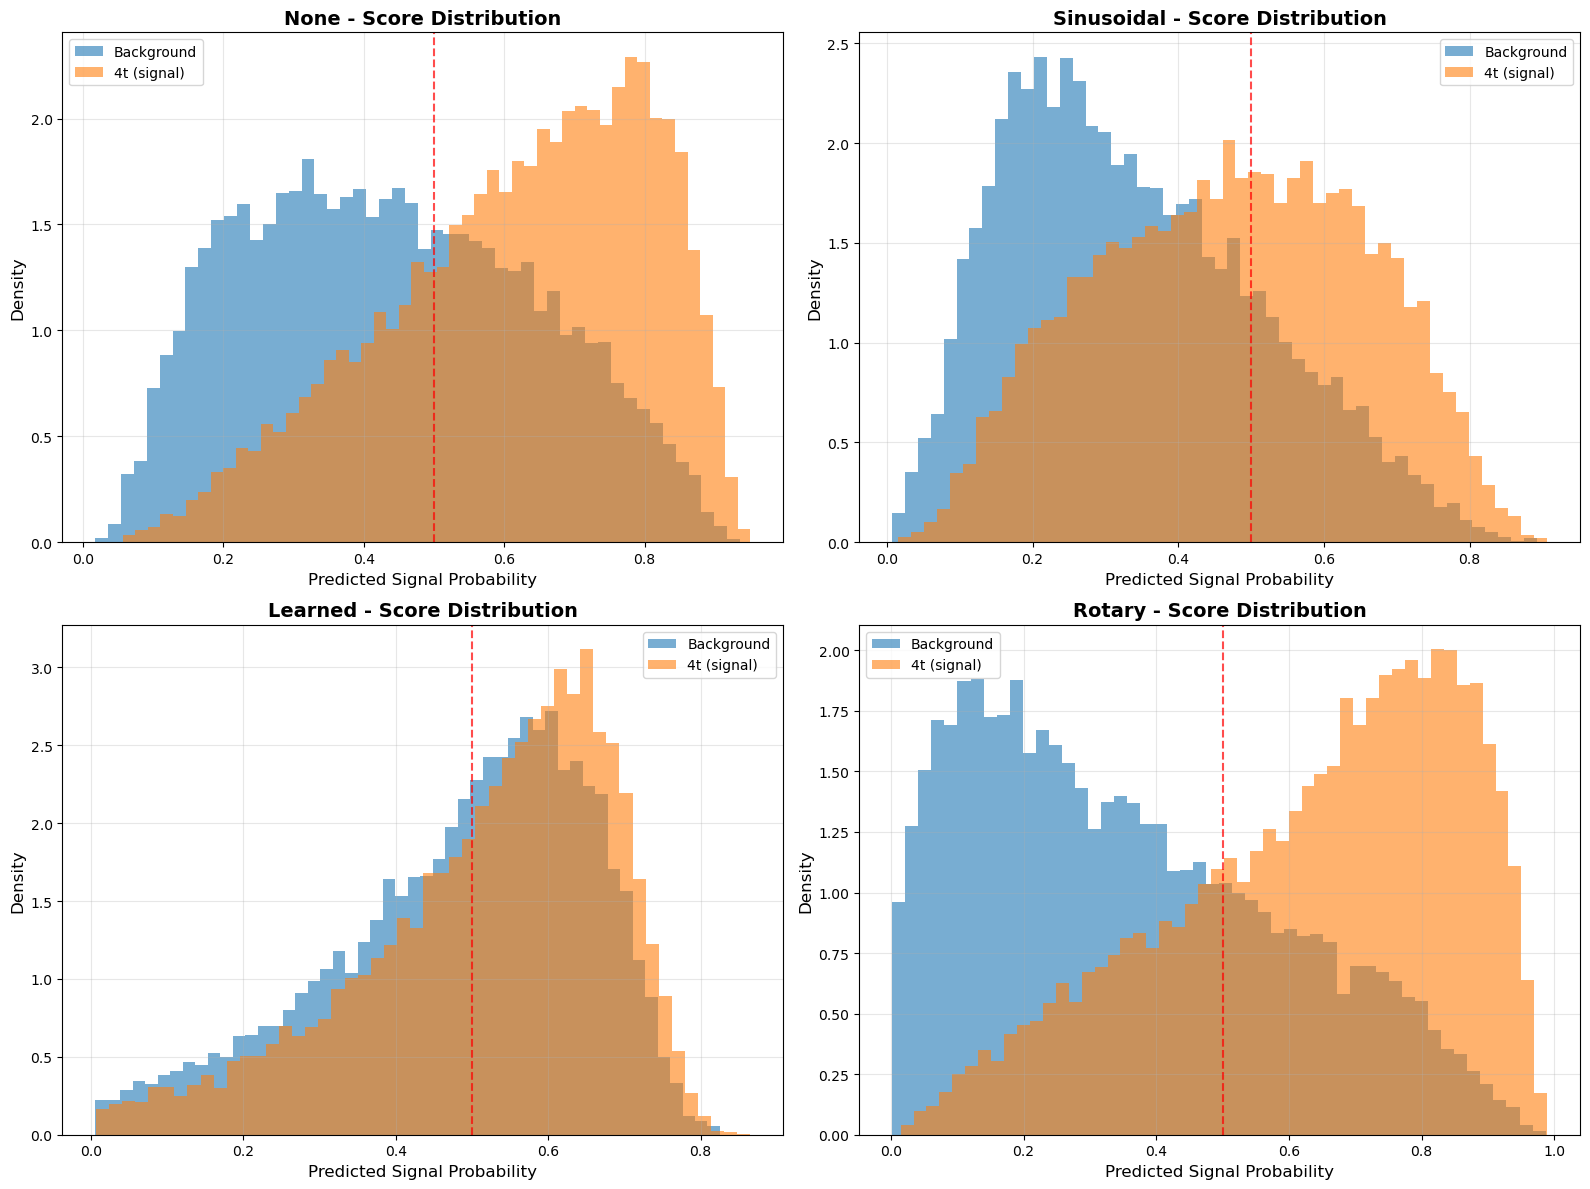


Score distributions show how well the model separates the two classes
Good separation = distinct peaks for signal and background


In [25]:
# Visualize prediction score distributions
if inference_results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    pe_types_with_scores = []
    for run_id, metrics in inference_results.items():
        for pt, info in models_info.items():
            if info['run_id'] == run_id:
                pe_types_with_scores.append((pt, metrics))
                break
    
    for idx, (pe_type, metrics) in enumerate(pe_types_with_scores[:4]):
        ax = axes[idx]
        
        if isinstance(metrics, dict) and 'per_event_scores' in metrics and 'per_event_labels' in metrics:
            scores = metrics['per_event_scores']
            true_labels = metrics['per_event_labels']
            
            # Ensure scores and labels are numpy arrays
            if isinstance(scores, torch.Tensor):
                scores = scores.numpy()
            if isinstance(true_labels, torch.Tensor):
                true_labels = true_labels.numpy()
            
            # Ensure they are 1D arrays (flatten if needed)
            scores = np.asarray(scores).flatten()
            true_labels = np.asarray(true_labels).flatten()
            
            # Plot distributions for each class
            for class_idx in [0, 1]:
                class_mask = true_labels == class_idx
                # Check if mask is array-like and has any True values
                if hasattr(class_mask, 'sum') and class_mask.sum() > 0:
                    class_scores = scores[class_mask]
                    class_name = '4t (signal)' if class_idx == 1 else 'Background'
                    ax.hist(class_scores, bins=50, alpha=0.6, label=class_name, density=True)
            
            ax.set_xlabel('Predicted Signal Probability', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_title(f'{pe_type.capitalize()} - Score Distribution', 
                         fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.axvline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold=0.5')
        else:
            ax.text(0.5, 0.5, f'{pe_type}\nNo score data', 
                    ha='center', va='center', transform=ax.transAxes)
    
    # Hide unused subplots
    for idx in range(len(pe_types_with_scores), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nScore distributions show how well the model separates the two classes")
    print("Good separation = distinct peaks for signal and background")
else:
    print("No inference results available. Please run inference first.")

## 7. Summary and Conclusions

### Key Findings

This notebook demonstrates how different positional encoding strategies affect transformer-based classification:

#### **Positional Encoding Patterns**
- **Sinusoidal**: Fixed wave patterns with varying frequencies across dimensions
- **Learned**: Trainable embeddings optimized during training
- **Rotary (RoPE)**: Applied in attention mechanism (not additive to embeddings)
- **None**: No positional information (permutation invariant)

#### **Representation Evolution**
- Positional encodings create distinct token relationships early in the network
- Token similarity patterns differ significantly between PE types
- Class separation emerges and strengthens through transformer layers

#### **Performance Impact**
The metrics table above shows quantitative differences in classification performance. Key observations:
- Models with positional encoding generally outperform "none"
- Different PE strategies (sinusoidal vs learned vs rotary) show varying effectiveness
- PCA/t-SNE visualizations correlate with classification performance

#### **Why Positional Encoding Helps**
1. **Token Differentiation**: Adds unique information to each token position
2. **Sequence Structure**: Allows the model to learn position-dependent patterns
3. **Better Representations**: Creates more separable feature spaces (shown in PCA/t-SNE)
4. **Improved Classification**: Translates to higher AUROC and accuracy

### Particle Physics Context
For particle physics events, positional encoding can capture:
- Particle ordering (e.g., by pT, η, φ)
- Detector geometry information
- Spatial relationships between particles

However, true permutation invariance (PE=none) may be preferred when particle order is arbitrary.